## Explore Variation in Sex Ratio in India at District Level

Thanks to http://darribas.org/ for a brilliant explanation of Spatial explorations and Local Moran's I technique. This notebook is inspired by this [article](http://darribas.org/gds19/content/labs/lab_06.html). 

In [205]:
import geopandas as gpd
import matplotlib
from sodapy import Socrata
import pandas as pd
import urllib
import seaborn as sns
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz.splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import matplotlib.pyplot as plt
import numpy as np

### District-level Shape file
As the first step, I read in a district-level shape file for all of India. This data is available for download at ArcGIS hub link [here](https://hub.arcgis.com/datasets/2b37b84e67374fb98577c20ef8be6c62_0/geoservice?geometry=-33.479%2C-14.537%2C-60.373%2C42.345), and also using the API as shown below. 

In [5]:
geo_df = gpd.read_file('https://opendata.arcgis.com/datasets/2b37b84e67374fb98577c20ef8be6c62_0.geojson')\
            .to_crs({'init' : 'epsg:4326'})

To confirm if the dataset is complete, I plot it as a test step. There are multiple records in this shape file with the same district name. The next few steps ascertain that these are genuine records and not duplicates. 

Records in the geodataframe -  (594, 13) 
Unique districts in the dataset -  (589,)


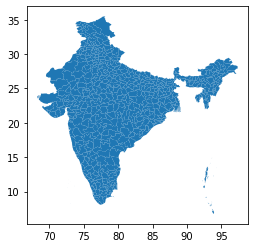

In [214]:
print('Records in the geodataframe - ', geo_df.shape, '\nUnique districts in the dataset - ', geo_df['NAME_2'].unique().shape)
geo_df.plot();

In [224]:
# Check for districts names having multiple records
geo_multiple_records_df = geo_df[['ID_2', 'NAME_2']].groupby('NAME_2').agg('count')\
                                                    .reset_index()\
                                                    .rename(columns={'ID_2':'Count'})
geo_multiple_records_df.loc[geo_multiple_records_df['Count']>1]

,NAME_2,Count
27,Aurangabad,2
79,Bilaspur,2
205,Hamirpur,2
252,Junagadh,2
437,Raigarh,2


In [43]:
geo_df.loc[geo_df['NAME_2'].isin(['Aurangabad', 'Bilaspur', 'Hamirpur', 'Junagadh', 'Raigarh']),\
           ['NAME_1', 'NAME_2', 'ID_2', 'geometry']]

,NAME_1,NAME_2,ID_2,geometry
79,Daman and Diu,Junagadh,120,"(POLYGON ((70.8885269165042 20.70976257324221,..."
159,Gujarat,Junagadh,133,"(POLYGON ((70.860969543457 20.7529182434082, 7..."
187,Uttar Pradesh,Hamirpur,524,"POLYGON ((79.96868896484369 26.0742607116702, ..."
211,Maharashtra,Aurangabad,309,"POLYGON ((75.70672607421881 20.6632404327393, ..."
257,Bihar,Aurangabad,65,"POLYGON ((84.7314529418946 25.0579204559327, 8..."
321,Maharashtra,Raigarh,330,"(POLYGON ((73.03819274902359 18.0520839691161,..."
391,Himachal Pradesh,Bilaspur,168,"POLYGON ((76.7150497436524 31.5883102416994, 7..."
399,Himachal Pradesh,Hamirpur,170,"POLYGON ((76.61237335205099 31.818790435791, 7..."
402,Chhattisgarh,Bilaspur,103,"(POLYGON ((83.0150680541995 22.2353706359864, ..."
456,Chhattisgarh,Raigarh,114,"POLYGON ((83.217987060547 22.78457069396971, 8..."


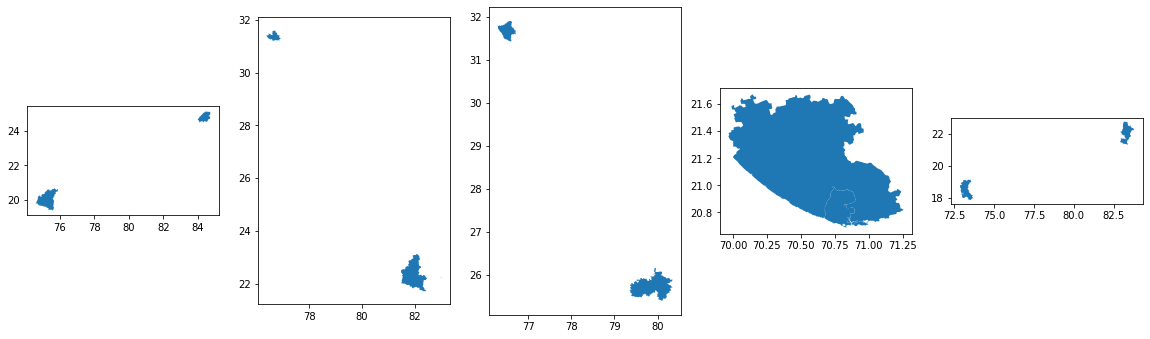

In [213]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,10))

geo_df.loc[(geo_df['NAME_2']=='Aurangabad')].plot(ax=ax1)
geo_df.loc[(geo_df['NAME_2']=='Bilaspur')].plot(ax=ax2)
geo_df.loc[(geo_df['NAME_2']=='Hamirpur')].plot(ax=ax3)
geo_df.loc[(geo_df['NAME_2']=='Junagadh')].plot(ax=ax4)
geo_df.loc[(geo_df['NAME_2']=='Raigarh')].plot(ax=ax5);

### District - level Demographics Data
Now that the shape file is ready, I ingest district-level demographics dataset from [Data.World](https://data.world/data) available [here](https://data.world/inderz/india-district-level-school-report-card) .

In [44]:
dist_demo_df = pd.read_csv('./District_Report_Card_2015_16.csv')

In [115]:
# Cleaning and standardizing important columns
dist_demo_tmp1_df = dist_demo_df.assign(State_name_cap = lambda x: x.STATNAME.str.title(), 
                                        District_Name_cap = lambda x: x.DISTNAME.str.title()
                                       )

dist_demo_tmp1_df['State_name_cap'] = dist_demo_tmp1_df['State_name_cap'].str.replace('&', 'And')\
                                                                         .str.replace('Islands','')
dist_demo_tmp1_df['District_Name_cap'] = dist_demo_tmp1_df['District_Name_cap'].str.replace('&', 'And')\
                                                                               .str.replace('Islands','')
                                                                               

dist_demo_tmp1_df.loc[dist_demo_tmp1_df['STATNAME'] == 'A & N ISLANDS', 'State_name_cap'] = 'Andaman And Nicobar'
dist_demo_tmp1_df.loc[dist_demo_tmp1_df['DISTNAME'] == 'ANDAMANS', 'District_Name_cap'] = 'Andaman'
dist_demo_tmp1_df.loc[dist_demo_tmp1_df['DISTNAME'] == 'NICOBARS', 'District_Name_cap'] = 'Nicobar'

In [148]:
# Cleaning and standardizing important columns
geo_tmp1_df = geo_df.assign(State_name_cap = lambda x: x.NAME_1.str.title(),
                            District_Name_cap = lambda x: x.NAME_2.str.title()
                           )

geo_tmp1_df['State_name_cap'] = geo_tmp1_df['State_name_cap'].str.replace('&', 'And')\
                                                                         .str.replace('Islands','')
geo_tmp1_df['District_Name_cap'] = geo_tmp1_df['District_Name_cap'].str.replace('&', 'And')\
                                                                               .str.replace('Islands','')
geo_tmp1_df.loc[geo_tmp1_df['NAME_1'] == 'Orissa', 'State_name_cap'] = 'Odisha'
geo_tmp1_df.loc[geo_tmp1_df['NAME_1'] == 'Uttaranchal', 'State_name_cap'] = 'Uttarakhand'

In [149]:
# Join the district demographics dataframe with the geodataframe on state name and district name. 
# The join on names is not recommended but here there are no IDs available.
dist_demo_geo_tmp2_df = geo_tmp1_df.merge(dist_demo_tmp1_df, left_on=['State_name_cap', 'District_Name_cap']\
                                                           , right_on=['State_name_cap', 'District_Name_cap']\
                                                           , how = 'left')\
                                    [['State_name_cap', 'District_Name_cap', 'SEXRATIO', 'geometry']]

In [150]:
# Check if our metric of interest is null for any records
dist_demo_geo_tmp2_df[dist_demo_geo_tmp2_df['SEXRATIO'].isnull()].head()

,State_name_cap,District_Name_cap,SEXRATIO,geometry
3,Andaman And Nicobar,Andaman,NaN,"(POLYGON ((92.5158309936525 10.8976411819458, ..."
4,Karnataka,Uttar Kannand,NaN,"(POLYGON ((74.4829177856448 14.0112495422364, ..."
6,Andaman And Nicobar,Nicobar,NaN,"(POLYGON ((93.7877273559571 6.8526401519777, 9..."
8,Andhra Pradesh,Adilabad,NaN,"POLYGON ((78.3362503051758 19.8831901550293, 7..."
13,Andhra Pradesh,Cuddapah,NaN,"POLYGON ((78.9461212158206 15.1946496963502, 7..."


In [151]:
# Assumption
# To handle cases of missing data, I am creating a state-average of the sex ratio metric and assign it to these records.
state_sex_ratio_mean_df = dist_demo_tmp1_df[['State_name_cap', 'SEXRATIO']].groupby('State_name_cap').mean().reset_index()
state_sex_ratio_mean_df.rename(columns={'SEXRATIO': 'State_Sex_Ratio_mean'}, inplace=True)

In [153]:
dist_demo_geo_tmp3_df = dist_demo_geo_tmp2_df.merge(state_sex_ratio_mean_df,\
                                                    left_on='State_name_cap',\
                                                    right_on='State_name_cap', how='left')

# Coalesce the sexratio values to eliminate nulls/missing data
dist_demo_geo_tmp3_df['sex_ratio_edited'] = dist_demo_geo_tmp3_df.SEXRATIO\
                                            .combine_first(dist_demo_geo_tmp3_df.State_Sex_Ratio_mean)

In [156]:
# Check that Sex ratio metric column has no nulls after correction above
dist_demo_geo_tmp3_df[dist_demo_geo_tmp3_df['sex_ratio_edited'].isnull()]['State_name_cap'].drop_duplicates().head()

Series([], Name: State_name_cap, dtype: object)

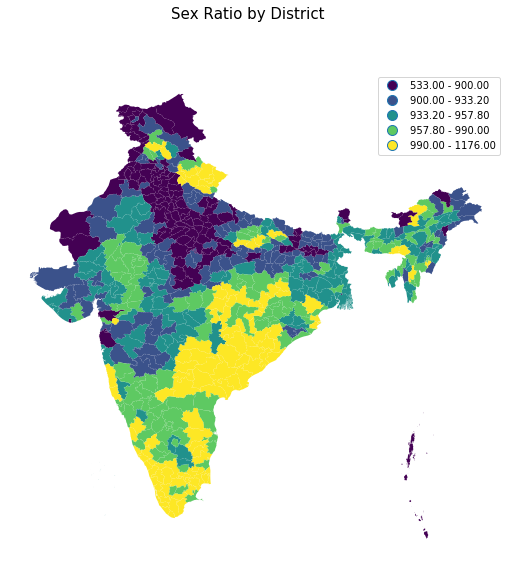

In [212]:
fig, ax = plt.subplots(1, figsize=(9, 9))

# Plot Quantiles of the metric for a visualization of the ranges of data we have
dist_demo_geo_tmp3_df.plot(column='sex_ratio_edited', scheme='Quantiles', legend=True, ax=ax)
ax.set_axis_off()
fig.suptitle('Sex Ratio by District', size=15);

## [Local Moran's I Methodology](http://ceadserv1.nku.edu/longa//geomed/ppa/doc/LocalI/LocalI.htm)

### Define Spatial weights matrix - 
A spatial weights matrix is the way geographical space is formally encoded into a numerical form so it is easy for a statistical method to understand. We create a Queen contiguity matrix (any geography having a common boundary or corner with the geography in focus is considered a neighbor.)     
Geographies that do not have any neighbors is considered an island. There are a few districts which really are islands and will thus be flagged out. Others could be flagged out due to inaccurate geometries. These need to be removed from the dataset before further analysis. 

In [167]:
# Use the weights function to calculate islands
w_q = weights.Queen.from_dataframe(dist_demo_geo_tmp3_df)
# islands are returned as indicies in the dataframe
w_q.islands

[3, 6, 18, 39, 57, 443]

In [169]:
# These districts have been flagged as islands and will be removed
dist_demo_geo_tmp3_df.iloc[w_q.islands]

,State_name_cap,District_Name_cap,SEXRATIO,geometry,State_Sex_Ratio_mean,sex_ratio_edited
3,Andaman And Nicobar,Andaman,NaN,"(POLYGON ((92.5158309936525 10.8976411819458, ...",859.000000,859.000000
6,Andaman And Nicobar,Nicobar,NaN,"(POLYGON ((93.7877273559571 6.8526401519777, 9...",859.000000,859.000000
18,Andhra Pradesh,Hyderabad,NaN,"POLYGON ((78.5058059692383 17.450159072876, 78...",996.615385,996.615385
39,Lakshadweep,Kavaratti,NaN,"(POLYGON ((73.0101394653322 8.28042030334484, ...",946.000000,946.000000
57,Andhra Pradesh,Rangareddi,NaN,"POLYGON ((77.91890710862032 16.8431605953018, ...",996.615385,996.615385
443,Chhattisgarh,Korba,971.0,"POLYGON ((82.7251204225455 22.0358029028034, 8...",996.312500,971.000000


In [184]:
# Create a dataframe without the islands
dist_demo_geo_tmp4_df = dist_demo_geo_tmp3_df.drop(index = w_q.islands, axis=1)\
                                             .reset_index()\
                                             .drop(columns='index')       

In [185]:
# Calculate weights for the edited dataset
w_q_corrected = weights.Queen.from_dataframe(dist_demo_geo_tmp4_df)
# Check that no more islands exist
w_q_corrected.islands

[]

In [186]:
# The weights matrix is row-standardized. This means that the weights for neighbors is normalized so that they sum up to 1.
# For Example - for zip 98001, the weight for each neighbor is normalized to 1/6=0.16667
w_q_corrected.transform = 'R'

In [192]:
print('District at index location 0 -', dist_demo_geo_tmp4_df.iloc[0]['District_Name_cap'],\
      '\nIndicies of Neighbors -', w_q_corrected.neighbors[0],\
      '\nNeighboring Districts - ', dist_demo_geo_tmp4_df.iloc[w_q_corrected.neighbors[0]]['District_Name_cap'].sort_values(),\
      '\nWeights after row transformation - ', w_q_corrected[0]
     )

District at index location 0 - Shimoga 
Indicies of Neighbors - [562, 2, 3, 555, 573] 
Neighboring Districts -  555      Chikmagalur
562       Davanagere
573           Haveri
2              Udupi
3      Uttar Kannand
Name: District_Name_cap, dtype: object 
Weights after row transformation -  {562: 0.2, 2: 0.2, 3: 0.2, 555: 0.2, 573: 0.2}


### Create Spatial Lag metric

Spatial lag is the product of the spatial weights matrix and a given variable. The way to interpret the spatial lag (w_sex_ratio_edited) for the first observation is as follow: Shimoga, where PreK unmet need is 995.00 is surrounded by districts where, on average, sex_ratio_edited is almost 994.36.    

| DIST    | sex_ratio_edited     | w_sex_ratio_edited     |
|---------|----------------------|------------------------|
| Shimoga | 995.0                | 994.36                 |

In [197]:
dist_demo_geo_tmp4_df['w_sex_ratio_edited'] = weights.lag_spatial(w_q_corrected, dist_demo_geo_tmp4_df['sex_ratio_edited'])
dist_demo_geo_tmp4_df[['State_name_cap','District_Name_cap', 'sex_ratio_edited', 'w_sex_ratio_edited']].head()

,State_name_cap,District_Name_cap,sex_ratio_edited,w_sex_ratio_edited
0,Karnataka,Shimoga,995.0,994.360000
1,Karnataka,Tumkur,979.0,977.342857
2,Karnataka,Udupi,1093.0,984.050000
3,Karnataka,Uttar Kannand,980.4,987.714286
4,Kerala,Alappuzha,1100.0,1065.250000


In [198]:
# Creating a column to store standardized metrics using the formula -
# (x-(mean of x)) / (standard deviation of x)
dist_demo_geo_tmp4_df['sex_ratio_edited_std'] = (dist_demo_geo_tmp4_df['sex_ratio_edited'] -\
                                                 dist_demo_geo_tmp4_df['sex_ratio_edited'].mean())\
                                                / dist_demo_geo_tmp4_df['sex_ratio_edited'].std()

In [200]:
# Calculating the spatial lag for this standardized metric, same as before
dist_demo_geo_tmp4_df['w_sex_ratio_edited_std'] = weights.lag_spatial(w_q_corrected,\
                                                                      dist_demo_geo_tmp4_df['sex_ratio_edited_std'])

### Interpreting the scatter plot
These values tell us how wide the gap is between a district and its neighbors, based on this one metric. This gap is used to classify the districts in one of the 4 quadrants -     
HH - high values surrounded by high values      
LL - low values nearby other low values      
HL - high values among low values      
LH - low values among high values     

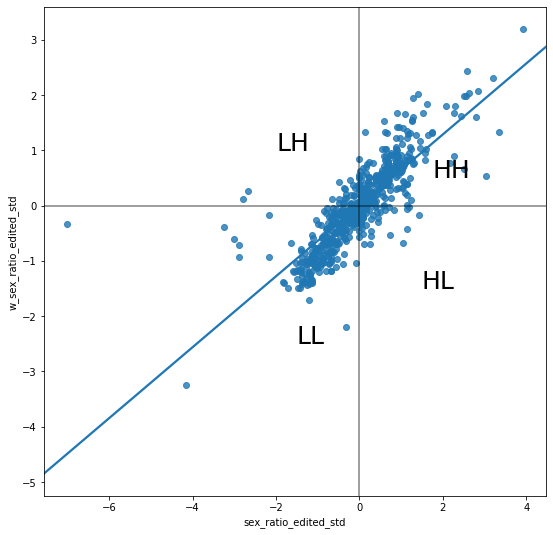

In [211]:
# Setup the figure and axis
fig, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='sex_ratio_edited_std', y='w_sex_ratio_edited_std', data=dist_demo_geo_tmp4_df, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25);

### Local Spatial autocorrelation
Local spatial autocorrelation relates to the clustering of values and identifying where in the geography are the clusters present. 

**Moran Plot**
The moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardized by substracting its mean and dividing it by its standard deviation.

| Quadrant | Code | Interpretation                           |
|----------|------|------------------------------------------|
| HH       | 1    | high values   surrounded by high values  |
| LL       | 3    | low values nearby   other low values     |
| HL       | 4    | high values among low   values           |
| LH       | 2    | low values among high   values           |

In [206]:
np.random.seed(12345)
lisa = esda.Moran_Local(dist_demo_geo_tmp4_df['sex_ratio_edited'], w_q_corrected)

In [207]:
# Break observations into significant or not
dist_demo_geo_tmp4_df['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
dist_demo_geo_tmp4_df['quadrant'] = lisa.q

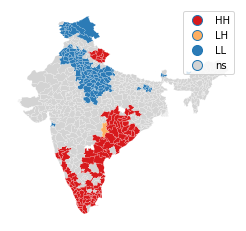

In [216]:
# Quick plot to see the results
lisa_cluster(lisa, dist_demo_geo_tmp4_df);

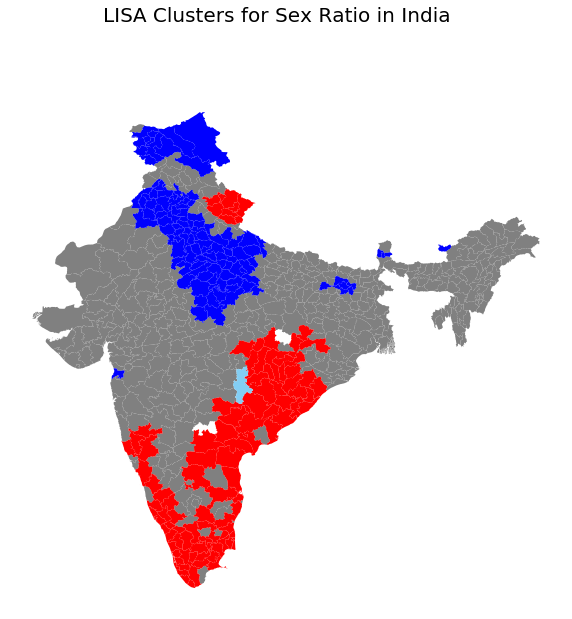

In [223]:
fig, ax = plt.subplots(1, figsize=(10, 10))
# Plot insignificant clusters
ns = dist_demo_geo_tmp4_df.loc[dist_demo_geo_tmp4_df['significant']==False]
ns.plot(ax=ax, color='grey')
# Plot HH clusters
hh = dist_demo_geo_tmp4_df.loc[(dist_demo_geo_tmp4_df['quadrant']==1) & (dist_demo_geo_tmp4_df['significant']==True)]
hh.plot(ax=ax, color='red')
# Plot LL clusters
ll = dist_demo_geo_tmp4_df.loc[(dist_demo_geo_tmp4_df['quadrant']==3) & (dist_demo_geo_tmp4_df['significant']==True)]
ll.plot(ax=ax, color='blue')
# Plot LH clusters
lh = dist_demo_geo_tmp4_df.loc[(dist_demo_geo_tmp4_df['quadrant']==2) & (dist_demo_geo_tmp4_df['significant']==True)]
lh.plot(ax=ax, color='#83cef4')
# Plot HL clusters
hl = dist_demo_geo_tmp4_df.loc[(dist_demo_geo_tmp4_df['quadrant']==4) & (dist_demo_geo_tmp4_df['significant']==True)]
hl.plot(ax=ax, color='#e59696')

fig.suptitle('LISA Clusters for Sex Ratio in India', size=20)
ax.set_axis_off()

## Observations and Next Steps

The above plot shows that parts of states of Punjab, Haryana, Rajasthan, MP and UP, etc. have low values of sex ratio, surrounded by other low values, making it a cluster of statistically significant low sex ratio in the country. Southern states do better in terms of sex ratios with parts of Kerala, Andhra Pradesh, Tamil Nadu and Karnataka being clusters of high values surrounded by other high values. This supports other sources of state-wide analysis of sex ratio in India. One such compact study is available [here](http://statisticstimes.com/demographics/sex-ratio-of-india.php)

As the next steps, one could look at other factors such as literacy(male and female) and healthcare opportunities in a similar way to understand if there is a strong correlation with what we see in the above plot.